## Modeling

In [2]:
# %run functions_ml.ipynb

El conjunto de datos contiene características principales de las aplicaciones en el mercado de Google Play Store. 

Definición de variables:

- building_id  = Identificador único de la aplicación 


**damage_rate**

In [79]:
import matplotlib.pyplot as plt
from datetime import datetime

In [9]:
import xgboost as xgb 
import pandas as pd
import numpy as np
import seaborn as sns
from datetime import date

from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier

import lightgbm as lgb
from sklearn.svm import SVR
from xgboost import XGBClassifier
# from vecstack import stacking

pd.set_option('display.max_columns', 1000)
pd.set_option('display.max_rows', 1000)

In [10]:
trainlabels = pd.read_csv("data/train_labels.csv")
dftrain = pd.read_csv("data/train_values.csv")
dftest = pd.read_csv("data/test_values.csv")
dfsample = pd.read_csv("data/submission_format.csv")
target = "damage_grade"

cols = dftrain.columns 
dftrain.columns = [i.lower().replace(" ", "_") for i in cols]

cols = dftest.columns
dftest.columns  = [i.lower().replace(" ", "_") for i in cols]

In [11]:
dftrain = pd.merge(dftrain, trainlabels, on = "building_id")

In [12]:
dftrain.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 260601 entries, 0 to 260600
Data columns (total 40 columns):
 #   Column                                  Non-Null Count   Dtype 
---  ------                                  --------------   ----- 
 0   building_id                             260601 non-null  int64 
 1   geo_level_1_id                          260601 non-null  int64 
 2   geo_level_2_id                          260601 non-null  int64 
 3   geo_level_3_id                          260601 non-null  int64 
 4   count_floors_pre_eq                     260601 non-null  int64 
 5   age                                     260601 non-null  int64 
 6   area_percentage                         260601 non-null  int64 
 7   height_percentage                       260601 non-null  int64 
 8   land_surface_condition                  260601 non-null  object
 9   foundation_type                         260601 non-null  object
 10  roof_type                               260601 non-null 

In [22]:
# import re

# def get_pattern(x, pattern):
#     preresult = re.findall(pattern, x)
    
#     if len(preresult) > 0:
#         result = preresult[0]
        
#     else:
#         result = np.nan
        
#     return result

# def preprocess_data(data):
#     data["size_num"]  = data["size"].apply(lambda x:   get_pattern(x, r"\d*\.?\d+"))
#     data["size_name"] = data["size"].apply(lambda x:   get_pattern(x, r"[a-zA-Z]+"))
#     data["size_name"] = data["size_name"].apply(lambda x: np.nan if x == "Varies"  else x)
#     data["size_kb"] = data.apply(lambda x: float(x["size_num"])*1000 if x["size_name"] == "M" else x["size_num"], axis = 1)
#     data["installs"] = data["installs"].apply(lambda x:   get_pattern(x.replace(",", ""), r"\d*\,?\d+"))
#     data["android_version"] = data["android_ver"].apply(lambda x: get_pattern(x, r"\d*\.?\d*\.?\d+"))
#     data["current_version"] = data["current_ver"].apply(lambda x: get_pattern(x, r"\d*\.?\d*\.?\d+"))
#     data["main_version"] = data.apply(lambda x: 0 if pd.isnull(x["current_version"]) else str(x["current_version"]).split(".")[0], axis = 1)
#     data["main_version"] = data["main_version"].fillna(0)
    
#     data["app_version"] = data.apply(lambda x: 0 if pd.isnull(x["android_version"]) else str(x["android_version"]).split(".")[0], axis = 1)
#     data["app_version"] = data["app_version"].fillna(0)
    
#     data["latest_android_ver"] = 10
#     data["price_float"] = data["price"].apply(lambda x: get_pattern(x, r"\d*\.?\d*\.?\d+"))
#     data["last_updated_date"] = pd.to_datetime(data["last_updated"])
#     data["size_kb"] = data["size_kb"].astype(float)
#     data["price_float"] = data["price_float"].astype(float)
#     return data


In [7]:
dftrain = preprocess_data(dftrain)
dftest = preprocess_data(dftest)

In [8]:
dftrain["rating"].value_counts()

1.000    4317
0.000    1471
Name: rating, dtype: int64

In [9]:
dftrain.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5788 entries, 0 to 5787
Data columns (total 24 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   id                  5788 non-null   int64         
 1   app                 5788 non-null   object        
 2   category            5788 non-null   object        
 3   rating              5788 non-null   float64       
 4   reviews             5788 non-null   int64         
 5   size                5788 non-null   object        
 6   installs            5788 non-null   object        
 7   type                5788 non-null   object        
 8   price               5788 non-null   object        
 9   content_rating      5788 non-null   object        
 10  genres              5788 non-null   object        
 11  last_updated        5788 non-null   object        
 12  current_ver         5788 non-null   object        
 13  android_ver         5788 non-null   object      

In [13]:
dftest.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 86868 entries, 0 to 86867
Data columns (total 39 columns):
 #   Column                                  Non-Null Count  Dtype 
---  ------                                  --------------  ----- 
 0   building_id                             86868 non-null  int64 
 1   geo_level_1_id                          86868 non-null  int64 
 2   geo_level_2_id                          86868 non-null  int64 
 3   geo_level_3_id                          86868 non-null  int64 
 4   count_floors_pre_eq                     86868 non-null  int64 
 5   age                                     86868 non-null  int64 
 6   area_percentage                         86868 non-null  int64 
 7   height_percentage                       86868 non-null  int64 
 8   land_surface_condition                  86868 non-null  object
 9   foundation_type                         86868 non-null  object
 10  roof_type                               86868 non-null  object
 11  gr

In [17]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelBinarizer

dict_encoders = dict()

cols_to_dummies = ["foundation_type"]

dftrain_tmp = dftrain.copy()
dftest_tmp = dftest.copy()

for col in cols_to_dummies:
    
    jobs_encoder = LabelBinarizer()
    jobs_encoder.fit(dftrain[col])

    transformed_train = jobs_encoder.transform(dftrain[col])
    transformed_test = jobs_encoder.transform(dftest[col]) 
    col_names = ["{}_{}".format(name_category, col) for name_category in jobs_encoder.classes_]
    ohe_df_trained = pd.DataFrame(transformed_train,  columns = col_names)
    ohe_df_test = pd.DataFrame(transformed_test,  columns = col_names)
    
    dftrain_tmp  = pd.concat([dftrain_tmp, ohe_df_trained], axis = 1).drop([col], axis = 1)
    dftest_tmp  = pd.concat([dftest_tmp, ohe_df_test], axis = 1).drop([col], axis = 1)

In [18]:
dftest_tmp.head()

,building_id,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,roof_type,ground_floor_type,other_floor_type,position,plan_configuration,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,has_superstructure_mud_mortar_brick,has_superstructure_cement_mortar_brick,has_superstructure_timber,has_superstructure_bamboo,has_superstructure_rc_non_engineered,has_superstructure_rc_engineered,has_superstructure_other,legal_ownership_status,count_families,has_secondary_use,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other,h_foundation_type,i_foundation_type,r_foundation_type,u_foundation_type,w_foundation_type
0,300051,17,596,11307,3,20,7,6,t,n,f,q,s,d,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1,99355,6,141,11987,2,25,13,5,t,n,f,q,s,d,0,1,0,0,0,0,0,0,0,0,0,v,1,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,890251,22,19,10044,2,5,4,5,t,n,f,q,s,d,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,745817,26,39,633,1,0,19,3,t,x,v,j,t,d,0,0,0,0,0,1,0,0,0,0,0,v,2,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0
4,421793,17,289,7970,3,15,8,7,t,q,f,q,t,d,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


In [21]:
dftrain_ = dftrain_tmp.copy()
dftest_ = dftest_tmp.copy()


for type_id in ['plan_configuration']:
   
    for column_id, agg_func, func_name in [('age',np.mean,'avg'),
                                           ('age',np.var,'var'),
                                           ('age',np.max,'max'),
                                           ('age', np.min,'min'),
                                           ('age', np.mean, 'sum'),
                                           ('damage_grade',np.mean,'avg')]:
   
        tmp = dftrain_.groupby([type_id]).agg({column_id:agg_func}).reset_index()
        mean_df = dftrain_.groupby([type_id]).agg({column_id:agg_func}).reset_index()[[column_id, type_id]]
        mean_df.columns = [type_id+'_'+func_name+'_'+column_id, type_id]
        
        dftrain_ = pd.merge(dftrain_, mean_df,on = [type_id], how = 'left')
        dftest_ = pd.merge(dftest_, mean_df, on = [type_id], how = 'left')

### Clusterización

In [24]:
dftrain_.head(20)

,building_id,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,roof_type,ground_floor_type,other_floor_type,position,plan_configuration,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,has_superstructure_mud_mortar_brick,has_superstructure_cement_mortar_brick,has_superstructure_timber,has_superstructure_bamboo,has_superstructure_rc_non_engineered,has_superstructure_rc_engineered,has_superstructure_other,legal_ownership_status,count_families,has_secondary_use,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other,damage_grade,h_foundation_type,i_foundation_type,r_foundation_type,u_foundation_type,w_foundation_type,plan_configuration_avg_age,plan_configuration_var_age,plan_configuration_max_age,plan_configuration_min_age,plan_configuration_sum_age,plan_configuration_avg_damage_grade
0,802906,6,487,12198,2,30,6,5,t,n,f,q,t,d,1,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,3,0,0,1,0,0,26.563290,5378.810939,995,0,26.563290,2.243646
1,28830,8,900,2812,2,10,8,7,o,n,x,q,s,d,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,2,0,0,1,0,0,26.563290,5378.810939,995,0,26.563290,2.243646
2,94947,21,363,8973,2,10,5,5,t,n,f,x,t,d,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,3,0,0,1,0,0,26.563290,5378.810939,995,0,26.563290,2.243646
3,590882,22,418,10694,2,10,6,5,t,n,f,x,s,d,0,1,0,0,0,0,1,1,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,2,0,0,1,0,0,26.563290,5378.810939,995,0,26.563290,2.243646
4,201944,11,131,1488,3,30,8,9,t,n,f,x,s,d,1,0,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,3,0,0,1,0,0,26.563290,5378.810939,995,0,26.563290,2.243646
5,333020,8,558,6089,2,10,9,5,t,n,f,q,s,d,0,1,0,0,0,0,0,0,0,0,0,v,1,1,1,0,0,0,0,0,0,0,0,0,2,0,0,1,0,0,26.563290,5378.810939,995,0,26.563290,2.243646
6,728451,9,475,12066,2,25,3,4,n,n,x,q,s,d,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,3,0,0,1,0,0,26.563290,5378.810939,995,0,26.563290,2.243646
7,475515,20,323,12236,2,0,8,6,t,q,v,x,s,u,0,0,0,0,0,1,1,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,24.294327,4910.487361,995,0,24.294327,1.918334
8,441126,0,757,7219,2,15,8,6,t,q,f,q,s,d,0,1,0,0,0,0,1,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,2,0,0,1,0,0,26.563290,5378.810939,995,0,26.563290,2.243646
9,989500,26,886,994,1,0,13,4,t,n,v,j,s,d,0,0,0,0,0,1,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,26.563290,5378.810939,995,0,26.563290,2.243646


In [25]:
# cols_fill = ['age', 'count_floors_pre_eq', 'area_percentage', 'height_percentage']

# for col_fill  in cols_fill:
#     dftrain_[col_fill]  = dftrain_[col_fill].fillna(0)
#     dftest_[col_fill]  = dftest_[col_fill].fillna(0)

In [26]:
cols_cluster = ['age', 'count_floors_pre_eq', 'area_percentage', 'height_percentage']

In [27]:
from scipy.spatial.distance import cdist, pdist
from sklearn.cluster import KMeans, SpectralClustering
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import euclidean_distances, silhouette_score

X = dftrain_[cols_cluster].fillna(0.0)

scaler = StandardScaler()
X_std = scaler.fit_transform(X)

K = range(1, 20)

KM = [KMeans(n_clusters = k).fit(X_std) for k in K]
centroids = [k.cluster_centers_ for k in KM]
D_k = [cdist(X_std, cent, 'euclidean') for cent in centroids]
dist = [np.min(D,axis=1) for D in D_k]
avgWithinSS = [sum(d)/X_std.shape[0] for d in dist]

In [28]:
wcss = [sum(d**2) for d in dist]
tss  = sum(pdist(X)**2)/X.shape[0]
bss  = tss-wcss
kIdx = 10-1

fig, axs = plt.subplots( 1, 2, sharey = False, figsize = (23,7))
axs[0].plot(K, avgWithinSS, 'b*-')
axs[1].plot(K, bss/tss*100, 'b.--')


### Elbow plot
axs[0].grid(False, which = "major", axis = "y")
axs[0].set_xlabel('Number of clusters')
axs[0].set_ylabel('Average within-cluster sum of squares')
axs[0].set_title('Elbow for KMeans clustering')


### Variance explained
axs[1].grid(False, which = "major", axis = "y")
axs[1].set_xlabel('Number of clusters')
axs[1].set_ylabel('Percentage of variance explained')
axs[1].set_title('Elbow for KMeans clustering');

MemoryError: Unable to allocate 253. GiB for an array with shape (33956310300,) and data type float64

In [29]:
cols_cluster

['age', 'count_floors_pre_eq', 'area_percentage', 'height_percentage']

In [30]:
from scipy.spatial.distance import cdist, pdist
from sklearn.cluster import KMeans, SpectralClustering
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import euclidean_distances, silhouette_score

X = dftrain_[cols_cluster].fillna(dftrain_[cols_cluster].mean(axis = 0))

scaler = StandardScaler()
X_std = scaler.fit_transform(X)

cluster = KMeans(n_clusters = 7, random_state = 94)
dftrain_['cluster'] = cluster.fit_predict(X_std)
dftrain_.cluster.value_counts()

0    93097
1    57165
5    53167
4    38136
6    10967
3     6679
2     1390
Name: cluster, dtype: int64

In [31]:
X_test_cluster = dftest_[cols_cluster].fillna(dftest_[cols_cluster].mean(axis = 0))
X_std_test = scaler.transform(X_test_cluster)
dftest_["cluster"] = cluster.predict(X_std_test)
dftest_["cluster"].value_counts()

0    31321
1    18989
5    17697
4    12517
6     3600
3     2283
2      461
Name: cluster, dtype: int64

In [33]:
dftest_.info(null_counts = True, verbose = True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 86868 entries, 0 to 86867
Data columns (total 50 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   building_id                             86868 non-null  int64  
 1   geo_level_1_id                          86868 non-null  int64  
 2   geo_level_2_id                          86868 non-null  int64  
 3   geo_level_3_id                          86868 non-null  int64  
 4   count_floors_pre_eq                     86868 non-null  int64  
 5   age                                     86868 non-null  int64  
 6   area_percentage                         86868 non-null  int64  
 7   height_percentage                       86868 non-null  int64  
 8   land_surface_condition                  86868 non-null  object 
 9   roof_type                               86868 non-null  object 
 10  ground_floor_type                       86868 non-null  ob

C:\Users\Voxiva\Anaconda2\envs\udacityenv\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: null_counts is deprecated. Use show_counts instead
  """Entry point for launching an IPython kernel.


In [40]:
dftest_.select_dtypes(include=['int64', 'float64', 'int']).columns

Index(['building_id', 'geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id',
       'count_floors_pre_eq', 'age', 'area_percentage', 'height_percentage',
       'has_superstructure_adobe_mud', 'has_superstructure_mud_mortar_stone',
       'has_superstructure_stone_flag',
       'has_superstructure_cement_mortar_stone',
       'has_superstructure_mud_mortar_brick',
       'has_superstructure_cement_mortar_brick', 'has_superstructure_timber',
       'has_superstructure_bamboo', 'has_superstructure_rc_non_engineered',
       'has_superstructure_rc_engineered', 'has_superstructure_other',
       'count_families', 'has_secondary_use', 'has_secondary_use_agriculture',
       'has_secondary_use_hotel', 'has_secondary_use_rental',
       'has_secondary_use_institution', 'has_secondary_use_school',
       'has_secondary_use_industry', 'has_secondary_use_health_post',
       'has_secondary_use_gov_office', 'has_secondary_use_use_police',
       'has_secondary_use_other', 'h_foundation_type', 'i_f

In [ ]:
dftest_.info

In [32]:
dftrain_.to_csv("data/dftrain_preprocess.csv", index = False)
dftest_.to_csv("data/dftest_preprocess.csv", index = False)

In [72]:
dftrain = pd.read_csv("datasets/dftrain_preprocess.csv")
dftrain = dftrain.fillna(dftrain["main_version"].mean())
dftest  = pd.read_csv("datasets/dftest_preprocess.csv")

In [41]:
cols_train = ['geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id',
       'count_floors_pre_eq', 'age', 'area_percentage', 'height_percentage',
       'has_superstructure_adobe_mud', 'has_superstructure_mud_mortar_stone',
       'has_superstructure_stone_flag',
       'has_superstructure_cement_mortar_stone',
       'has_superstructure_mud_mortar_brick',
       'has_superstructure_cement_mortar_brick', 'has_superstructure_timber',
       'has_superstructure_bamboo', 'has_superstructure_rc_non_engineered',
       'has_superstructure_rc_engineered', 'has_superstructure_other',
       'count_families', 'has_secondary_use', 'has_secondary_use_agriculture',
       'has_secondary_use_hotel', 'has_secondary_use_rental',
       'has_secondary_use_institution', 'has_secondary_use_school',
       'has_secondary_use_industry', 'has_secondary_use_health_post',
       'has_secondary_use_gov_office', 'has_secondary_use_use_police',
       'has_secondary_use_other', 'plan_configuration_avg_age',
       'plan_configuration_var_age', 'plan_configuration_max_age',
       'plan_configuration_min_age', 'plan_configuration_sum_age',
       'plan_configuration_avg_damage_grade', 'cluster']

print(len(cols_train))

37


In [42]:
dftrain_[cols_train].head()

,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,has_superstructure_mud_mortar_brick,has_superstructure_cement_mortar_brick,has_superstructure_timber,has_superstructure_bamboo,has_superstructure_rc_non_engineered,has_superstructure_rc_engineered,has_superstructure_other,count_families,has_secondary_use,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other,plan_configuration_avg_age,plan_configuration_var_age,plan_configuration_max_age,plan_configuration_min_age,plan_configuration_sum_age,plan_configuration_avg_damage_grade,cluster
0,6,487,12198,2,30,6,5,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,26.56329,5378.810939,995,0,26.56329,2.243646,0
1,8,900,2812,2,10,8,7,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,26.56329,5378.810939,995,0,26.56329,2.243646,1
2,21,363,8973,2,10,5,5,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,26.56329,5378.810939,995,0,26.56329,2.243646,0
3,22,418,10694,2,10,6,5,0,1,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,26.56329,5378.810939,995,0,26.56329,2.243646,0
4,11,131,1488,3,30,8,9,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,26.56329,5378.810939,995,0,26.56329,2.243646,5


In [43]:
dftrain_[cols_train+[target]].corr().loc[target].sort_values()

has_superstructure_cement_mortar_brick   -0.254131
has_superstructure_rc_engineered         -0.179014
has_superstructure_rc_non_engineered     -0.158145
area_percentage                          -0.125221
has_secondary_use_hotel                  -0.097942
has_secondary_use_rental                 -0.083754
has_secondary_use                        -0.079630
geo_level_1_id                           -0.072347
has_superstructure_timber                -0.069852
has_superstructure_bamboo                -0.063051
has_superstructure_cement_mortar_stone   -0.060295
has_superstructure_other                 -0.030224
has_secondary_use_institution            -0.028728
has_secondary_use_other                  -0.016334
has_secondary_use_school                 -0.011692
has_secondary_use_industry               -0.011024
plan_configuration_var_age               -0.009496
has_secondary_use_gov_office             -0.009378
has_secondary_use_health_post            -0.008543
cluster                        

In [45]:
dftrain_[target].value_counts()

2    148259
3     87218
1     25124
Name: damage_grade, dtype: int64

<AxesSubplot:>

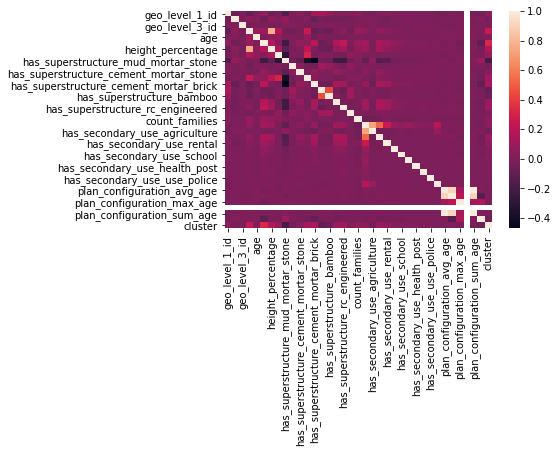

In [47]:
sns.heatmap(dftrain_[cols_train].corr())

### Validation

In [49]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_squared_log_error
from sklearn.linear_model import LinearRegression

In [51]:
X_train, y_train = dftrain_.loc[:, cols_train], dftrain.loc[:,target]
X_test = dftest_.loc[:, cols_train]

In [52]:
from sklearn.preprocessing import StandardScaler, MaxAbsScaler, MinMaxScaler, RobustScaler
std_scaler = RobustScaler()
X_train_encode = std_scaler.fit_transform(X_train[cols_train])
X_train_encode = pd.DataFrame(X_train_encode)
# X_train_encode.columns = cols_train
X_train_encode.index = y_train.index

X_test_encode = std_scaler.transform(X_test[cols_train])
X_test_encode = pd.DataFrame(X_test_encode)
# X_test_encode.columns = cols_train

In [53]:
from sklearn.metrics import f1_score, f1_score
from sklearn.metrics import log_loss

In [68]:
%%time
#### xgboost

model_xgb = xgb.XGBClassifier(objective = 'objective=multi:softmax', 
                              learning_rate = 0.001, n_estimators = 1500, 
                              max_depth = 5,  reg_alpha = 0.2, 
                              booster  = "gbtree", importance_type = "gain")

model_xgb.fit(X_train[cols_train], y_train, verbose = True)

C:\Users\Voxiva\Anaconda2\envs\udacityenv\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[02:35:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Wall time: 5min 43s


In [70]:
y_pred_xgb_probs = model_xgb.predict(X_test[cols_train])

In [73]:
np.unique(y_pred_xgb_probs, return_counts=True)

(array([1, 2, 3], dtype=int64), array([ 2720, 67294, 16854], dtype=int64))

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

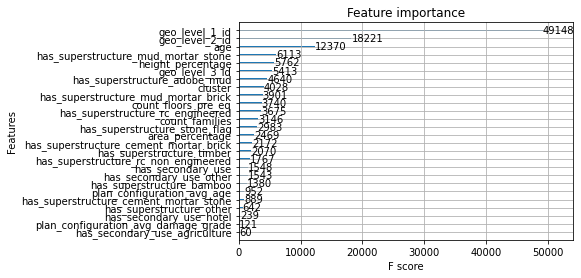

In [58]:
from xgboost import plot_importance
plot_importance(model_xgb)

In [80]:
dfsample[target] = y_pred_xgb_probs
dfsample.columns = ["building_id", target]
dfsample[["building_id", target]].to_csv("data/submission_{}_xgb.csv".format(datetime.now().strftime("%Y%m%d")), index=False)
dfsample[target].value_counts()

2    67294
3    16854
1     2720
Name: damage_grade, dtype: int64

In [ ]:
#### lighgbm

In [123]:
# X_test[cols_train].info(verbose = True, null_counts = True)

In [81]:
import lightgbm as lgb

model_lgb = lgb.LGBMClassifier(objective ='multiclass',
    n_estimators = 1000,
    boosting_type='gbdt',
    learning_rate = 0.001,
    max_depth = 10, 
    verbose = 1, 
    seed = 94)

model_lgb.fit(X_train[cols_train], y_train)


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017700 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 795
[LightGBM] [Info] Number of data points in the train set: 260601, number of used features: 36
[LightGBM] [Info] Start training from score -2.339167
[LightGBM] [Info] Start training from score -0.564030
[LightGBM] [Info] Start training from score -1.094580


LGBMClassifier(learning_rate=0.001, max_depth=10, n_estimators=1000,
               objective='multiclass', seed=94, verbose=1)

In [82]:
y_pred_lgb_probs = model_lgb.predict(X_test[cols_train])

In [83]:
dfsample[target] = y_pred_lgb_probs
dfsample.columns = ["building_id", target]
dfsample[["building_id", target]].to_csv("data/submission_{}_lightgbm.csv".format(datetime.now().strftime("%Y%m%d")), index=False)
dfsample[target].value_counts()

2    70594
3    15525
1      749
Name: damage_grade, dtype: int64

In [ ]:
X_test.info()

### Ensamblado

In [93]:
from vecstack import stacking
X_train_col, y_train_col = dftrain_.loc[:, cols_train], dftrain_.loc[:,target]
X_test_col = dftest_.loc[:, cols_train]


models_col = [
            lgb.LGBMClassifier(boosting_type = 'gbdt',
                      learning_rate= 0.001, 
                      n_estimators = 400,
                       objective="multiclass",
                      max_depth = 5),
    
    XGBClassifier(random_state=0, n_jobs=-1, 
                  learning_rate= 0.002, 
             n_estimators=400, max_depth=5, 
                  objective="objective=multi:softmax"),
    
    XGBClassifier(random_state = 10, 
                  n_jobs=-1, learning_rate=0.001, 
                 n_estimators=1000, 
                  max_depth=10, 
                  objective="objective=multi:softmax"),
    
    
    lgb.LGBMClassifier(boosting_type = 'goss',
                      learning_rate= 0.001, 
                      n_estimators = 300, 
                     objective="multiclass",
                      max_depth = 3)
]


S_train_col, S_test_col = stacking(models_col,                     # list of models
                           X_train_col, y_train_col, X_test_col,   # data
                           regression = False,            # regression task (if you need 
                                                       #     classification - set to False)
                           mode = 'oof_pred',        # mode: oof for train set, predict test 

                           save_dir = None,              # do not save result and log (to save 
                           needs_proba = False,                            #     in current dir - set to '.')
                           metric = log_loss, # metric: callable
                           n_folds = 2,                  # number of folds
                           shuffle = True,               # shuffle the data
                           stratified=True,
                           random_state = 0,             # ensure reproducibility
                           verbose = 2)                  # print all info

task:         [classification]
n_classes:    [3]
metric:       [accuracy_score]
mode:         [oof_pred]
n_models:     [4]

model  0:     [LGBMClassifier]
    fold  0:  [0.62773118]
    fold  1:  [0.62861090]
    ----
    MEAN:     [0.62817104] + [0.00043986]
    FULL:     [0.62817104]

    Fitting on full train set...

model  1:     [XGBClassifier]


C:\Users\Voxiva\Anaconda2\envs\udacityenv\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[02:59:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
    fold  0:  [0.65529044]


C:\Users\Voxiva\Anaconda2\envs\udacityenv\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[02:59:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
    fold  1:  [0.65600153]
    ----
    MEAN:     [0.65564599] + [0.00035555]
    FULL:     [0.65564599]

    Fitting on full train set...



C:\Users\Voxiva\Anaconda2\envs\udacityenv\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[03:00:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
model  2:     [XGBClassifier]


C:\Users\Voxiva\Anaconda2\envs\udacityenv\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[03:01:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
    fold  0:  [0.69540525]


C:\Users\Voxiva\Anaconda2\envs\udacityenv\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[03:05:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
    fold  1:  [0.69361474]
    ----
    MEAN:     [0.69450999] + [0.00089526]
    FULL:     [0.69451000]

    Fitting on full train set...



C:\Users\Voxiva\Anaconda2\envs\udacityenv\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[03:09:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
model  3:     [LGBMClassifier]
    fold  0:  [0.56891352]
    fold  1:  [0.56891021]
    ----
    MEAN:     [0.56891186] + [0.00000165]
    FULL:     [0.56891186]

    Fitting on full train set...



In [94]:
S_test_col

array([[3, 3, 3, 2],
       [2, 2, 2, 2],
       [2, 2, 2, 2],
       ...,
       [2, 2, 2, 2],
       [2, 2, 2, 2],
       [2, 2, 1, 2]])

In [103]:
y_pred_col_stack  = S_test_col[:,0::2].mean(axis = 1)

In [105]:
np.unique(np.floor(y_pred_col_stack), return_counts=True)

(array([1., 2., 3.]), array([ 4559, 74979,  7330], dtype=int64))

In [108]:
dfsample.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 86868 entries, 0 to 86867
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   building_id   86868 non-null  int64  
 1   damage_grade  86868 non-null  float64
dtypes: float64(1), int64(1)
memory usage: 1.3 MB


In [112]:
dfsample[target] = np.floor(y_pred_col_stack)
dfsample.columns = ["building_id", target]
dfsample[target] = dfsample[target].astype(int)
dfsample[["building_id", target]].to_csv("data/submission_{}_stack.csv".format(datetime.now().strftime("%Y%m%d")), index=False)
dfsample[target].value_counts()

2    74979
3     7330
1     4559
Name: damage_grade, dtype: int64

### neural net

In [115]:
import tensorflow as tf
from keras import losses
from keras import metrics
from keras import optimizers

In [117]:
len(cols_train)

37

In [116]:
from sklearn.model_selection import train_test_split

X_train_partial, X_valid, y_train_partial, y_valid = train_test_split(X_train_encode, y_train,
                                                                      test_size = 0.3, 
                                                                      random_state = 94, 
                                                                      stratify = y_train)

In [125]:
num_epochs = 500
batch_size = 128 

model_total = tf.keras.Sequential()
model_total.add(tf.keras.Input(shape = (37, ), name="input_red"))
model_total.add(tf.keras.layers.Dense(256, activation = 'relu'))
model_total.add(tf.keras.layers.Dense(128, activation='relu') )
model_total.add(tf.keras.layers.Dense(64, activation='relu'))
model_total.add(tf.keras.layers.Dense(1, activation = 'softmax'))

model_total.compile(optimizer=tf.keras.optimizers.RMSprop(lr=0.001),
                        loss = 'categorical_crossentropy',  
                        metrics=[tf.keras.metrics.Accuracy()])

In [126]:
model_total.fit(X_train_encode.to_numpy(), 
              y_train.to_numpy(), 
              epochs = num_epochs, 
              batch_size = batch_size,
              validation_data = (X_valid, y_valid),
              verbose = 1)

Epoch 1/500
2036/2036 [==============================] - 6s 3ms/step - loss: 0.0000e+00 - accuracy: 0.0959 - val_loss: 0.0000e+00 - val_accuracy: 0.0964
Epoch 2/500
2036/2036 [==============================] - 6s 3ms/step - loss: 0.0000e+00 - accuracy: 0.0971 - val_loss: 0.0000e+00 - val_accuracy: 0.0964
Epoch 3/500
2036/2036 [==============================] - 6s 3ms/step - loss: 0.0000e+00 - accuracy: 0.0973 - val_loss: 0.0000e+00 - val_accuracy: 0.0964
Epoch 4/500
2036/2036 [==============================] - 6s 3ms/step - loss: 0.0000e+00 - accuracy: 0.0965 - val_loss: 0.0000e+00 - val_accuracy: 0.0964
Epoch 5/500
2036/2036 [==============================] - 6s 3ms/step - loss: 0.0000e+00 - accuracy: 0.0976 - val_loss: 0.0000e+00 - val_accuracy: 0.0964
Epoch 6/500
2036/2036 [==============================] - 6s 3ms/step - loss: 0.0000e+00 - accuracy: 0.0971 - val_loss: 0.0000e+00 - val_accuracy: 0.0964
Epoch 7/500
2036/2036 [==============================] - 5s 3ms/step - loss: 0.000

2036/2036 [==============================] - 5s 3ms/step - loss: 0.0000e+00 - accuracy: 0.0953 - val_loss: 0.0000e+00 - val_accuracy: 0.0964
Epoch 55/500
2036/2036 [==============================] - 6s 3ms/step - loss: 0.0000e+00 - accuracy: 0.0955 - val_loss: 0.0000e+00 - val_accuracy: 0.0964
Epoch 56/500
2036/2036 [==============================] - 5s 3ms/step - loss: 0.0000e+00 - accuracy: 0.0962 - val_loss: 0.0000e+00 - val_accuracy: 0.0964
Epoch 57/500
2036/2036 [==============================] - 6s 3ms/step - loss: 0.0000e+00 - accuracy: 0.0961 - val_loss: 0.0000e+00 - val_accuracy: 0.0964
Epoch 58/500
2036/2036 [==============================] - 6s 3ms/step - loss: 0.0000e+00 - accuracy: 0.0962 - val_loss: 0.0000e+00 - val_accuracy: 0.0964
Epoch 59/500
2036/2036 [==============================] - 6s 3ms/step - loss: 0.0000e+00 - accuracy: 0.0964 - val_loss: 0.0000e+00 - val_accuracy: 0.0964
Epoch 60/500
2036/2036 [==============================] - 6s 3ms/step - loss: 0.0000e+00 

2036/2036 [==============================] - 5s 3ms/step - loss: 0.0000e+00 - accuracy: 0.0974 - val_loss: 0.0000e+00 - val_accuracy: 0.0964
Epoch 108/500
2036/2036 [==============================] - 5s 3ms/step - loss: 0.0000e+00 - accuracy: 0.0949 - val_loss: 0.0000e+00 - val_accuracy: 0.0964
Epoch 109/500
2036/2036 [==============================] - 5s 3ms/step - loss: 0.0000e+00 - accuracy: 0.0965 - val_loss: 0.0000e+00 - val_accuracy: 0.0964
Epoch 110/500
2036/2036 [==============================] - 6s 3ms/step - loss: 0.0000e+00 - accuracy: 0.0959 - val_loss: 0.0000e+00 - val_accuracy: 0.0964
Epoch 111/500
2036/2036 [==============================] - 5s 3ms/step - loss: 0.0000e+00 - accuracy: 0.0962 - val_loss: 0.0000e+00 - val_accuracy: 0.0964
Epoch 112/500
2036/2036 [==============================] - 5s 3ms/step - loss: 0.0000e+00 - accuracy: 0.0961 - val_loss: 0.0000e+00 - val_accuracy: 0.0964
Epoch 113/500
2036/2036 [==============================] - 5s 3ms/step - loss: 0.000

Epoch 160/500
2036/2036 [==============================] - 5s 3ms/step - loss: 0.0000e+00 - accuracy: 0.0973 - val_loss: 0.0000e+00 - val_accuracy: 0.0964
Epoch 161/500
2036/2036 [==============================] - 5s 3ms/step - loss: 0.0000e+00 - accuracy: 0.0962 - val_loss: 0.0000e+00 - val_accuracy: 0.0964
Epoch 162/500
2036/2036 [==============================] - 5s 3ms/step - loss: 0.0000e+00 - accuracy: 0.0962 - val_loss: 0.0000e+00 - val_accuracy: 0.0964
Epoch 163/500
2036/2036 [==============================] - 5s 3ms/step - loss: 0.0000e+00 - accuracy: 0.0958 - val_loss: 0.0000e+00 - val_accuracy: 0.0964
Epoch 164/500
2036/2036 [==============================] - 5s 3ms/step - loss: 0.0000e+00 - accuracy: 0.0953 - val_loss: 0.0000e+00 - val_accuracy: 0.0964
Epoch 165/500
2036/2036 [==============================] - 5s 3ms/step - loss: 0.0000e+00 - accuracy: 0.0968 - val_loss: 0.0000e+00 - val_accuracy: 0.0964
Epoch 166/500
2036/2036 [==============================] - 5s 3ms/step

KeyboardInterrupt: 

In [ ]:
y_pred_total = model_total.predict(X_test_encode)
plt.hist(y_pred_total)

In [ ]:
y_pred_net = model_total.predict(X_test_encode)
dfsample["rating"] = np.where(y_pred_net > 0.9, 1, 0)
dfsample.columns = ["id", "rating"]
dfsample[["id", "rating"]].to_csv("datasets/submission_{}_net.csv".format(datetime.now().strftime("%Y%m%d")), index=False)

In [ ]:
dfsample.rating.value_counts()

In [ ]:
y_pred_net

In [ ]:
pred_probs = (1 - y_pred_net.ravel() + y_pred_lr + y_pred_lgb_probs + y_pred_xgb_probs[:, 0] )/4
plt.hist(pred_probs)

In [ ]:
pred_probs
dfsample["rating"] = np.where(pred_probs > 0.3, 0, 1)
dfsample.columns = ["id", "rating"]
dfsample[["id", "rating"]].to_csv("datasets/submission_{}_stck.csv".format(datetime.now().strftime("%Y%m%d")), index=False)
dfsample.rating.value_counts()

In [ ]:
dfsample["rating"] = np.where(y_pred_col_stack>0.76,1, 0)
dfsample.columns = ["id", "rating"]
dfsample[["id", "rating"]].to_csv("datasets/submission_18102019_stack.csv", index=False)

In [ ]:
dfsample["rating"] = np.where(preds_col>0.7, 1, 0)
dfsample.columns = ["id", "rating"]

dfsample[["id", "rating"]].to_csv("datasets/submission_18102019_xgb_07.csv", index=False)

In [ ]:
plt.hist(preds_col)

In [ ]:
dfsample.rating.value_counts()

### Sending submission

In [ ]:
X_train, y_train = dftrain[cols_train], dftrain.price
X_test = dftest[cols_train]

In [ ]:
y_train.min()

In [ ]:
reg_alpha_sys =  0.2
max_depth_sys = 4
n_estimators_sys = 3000
learning_rate = 0.02

params = {
'reg_alpha': reg_alpha_sys,
'max_depth': max_depth_sys,
'n_estimators': n_estimators_sys,
'learning_rate': learning_rate,
'objective': "reg:squarederror",
'modelo': "xgboost",
'silent':1
}


train_dmatrix = xgb.DMatrix(data = X_train[cols_train], label = y_train)
test_dmatrix = xgb.DMatrix(data = X_test[cols_train])


# param = {'max_depth':4, 'eta':1,  'objective':'reg:squarederror' }
num_round = 3000

bst = xgb.train(params, train_dmatrix, num_round, feval = rmsle)

y_pred = bst.predict(test_dmatrix)

In [ ]:
# getFeatureImportance(bst, X_train, "asd")

### Stacking of lisghtgbm

In [ ]:
X_train, y_train = dftrain[cols_train], dftrain.price
X_test = dftest[cols_train]

In [ ]:
models = [
    lgb.LGBMRegressor(boosting_type = 'dart',n_estimators = 3000, max_depth = 3),

    XGBRegressor(random_state=0, n_jobs=-1, learning_rate= 0.02, 
             n_estimators=3000, max_depth=3, objective="reg:squarederror"),
    
    XGBRegressor(random_state=0, n_jobs=-1, learning_rate=0.1, 
                 n_estimators=3000, max_depth=3, objective="reg:squarederror")
]

In [ ]:
X_train, y_train = dftrain[cols_train], dftrain.price
X_test = dftest[cols_train]

models = [
    lgb.LGBMRegressor(boosting_type = 'dart',n_estimators = 3000, max_depth = 3),

    XGBRegressor(random_state=0, n_jobs=-1, learning_rate= 0.02, 
             n_estimators=3000, max_depth=3, objective="reg:squarederror"),
    
    XGBRegressor(random_state=0, n_jobs=-1, learning_rate=0.1, 
                 n_estimators=3000, max_depth=3, objective="reg:squarederror")
]


S_train, S_test = stacking(models,                     # list of models
                           X_train, y_train, X_test,   # data
                           regression=True,            # regression task (if you need 
                                                       #     classification - set to False)
                           mode='oof_pred_bag',        # mode: oof for train set, predict test 
                                                       #     set in each fold and find mean
                           save_dir=None,              # do not save result and log (to save 
                                                       #     in current dir - set to '.')
                           metric = mean_squared_error, # metric: callable
                           n_folds=4,                  # number of folds
                           shuffle = True,               # shuffle the data
                           random_state=0,             # ensure reproducibility
                           verbose=2)                  # print all info

In [ ]:
1

In [ ]:
model = XGBRegressor(random_state=0, n_jobs=-1, learning_rate=0.01, 
                     n_estimators=200, max_depth=3)
    
# Fit 2nd level model
model = model.fit(S_train, y_train)

# Predict
y_pred = model.predict(S_test)
y_pred = np.round(y_pred, 0)
# Final prediction score
# print('Final prediction score: [%.8f]' % mean_absolute_error(y_test, y_pred))

### Linear regression

In [ ]:
ln = LinearRegression(normalize = True)
ln.fit(X_train[cols_train], y_train)
preds_ln = ln.predict(X_test[cols_train])
preds_ln = preds_ln

preds_ln = np.where(preds_ln<=0, -1*preds_ln, preds_ln)

In [ ]:
y_pred.max()

In [ ]:
S_test.mean(axis = 1)

In [ ]:
X_test.shape

In [ ]:
# X_test["price"] = (preds_ln + y_pred)/2
# X_test["price"] = y_t
# y_preds = np.where(preds_ln>60000, preds_ln, y_pred)

X_test["pred"] = S_test.mean(axis = 1)
# y_preds*2
X_test["xgboost_pred"] = y_pred
X_test["lineal_pred"] = preds_ln

In [ ]:
dfsample["price"].describe()

In [ ]:
dfsample["price"].describe()

In [ ]:
dftrain.price.min()

In [ ]:
dfsample["price"] = np.round(y_pred,0)
dfsample[["Id", "price"]].to_csv("datasets/submission_24072020_v10.csv", index=False)
# (X_test["pred"].values + y_pred)/2
# dfsample["xgboost"] = y_pred

In [ ]:
dfsample.sort_values("price", ascending = False)

In [ ]:
dfsample[dfsample.price<0]  = np.round(dfsample.price.mean(), 0)

In [ ]:
dfsample.to_csv("datasets/submission_18072020.csv", index=False)

In [ ]:
def rmsle(predictions, dmat):
    labels = dmat.get_label()
    diffs = numpy.log(predictions + 1) - numpy.log(labels + 1)
    squared_diffs = numpy.square(diffs)
    avg = numpy.mean(squared_diffs)
    return ('RMSLE', numpy.sqrt(avg))